In [1]:
from itertools import accumulate
from sklearn.isotonic import IsotonicRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

df = pd.read_parquet("../anki-revlogs-10k/revlogs", filters=[("user_id", "=", 70)])
print(f"total rows: {len(df)}")
df["review_th"] = range(1, len(df) + 1)
df.sort_values(by=["card_id", "review_th"], inplace=True)

def cum_concat(x):
    return list(accumulate(x))

t_history_list = df.groupby("card_id", group_keys=False)["elapsed_seconds"].apply(
    lambda x: cum_concat([[max(0, i)] for i in x])
)
r_history_list = df.groupby("card_id", group_keys=False)["rating"].apply(
    lambda x: cum_concat([[i] for i in x])
)
df["r_history"] = [
    ",".join(map(str, item[:-1])) for sublist in r_history_list for item in sublist
]
df["t_history"] = [
    ",".join(map(str, item[:-1])) for sublist in t_history_list for item in sublist
]
df["y"] = df["rating"].map(lambda x: 1 if x > 1 else 0)
df.head()

total rows: 720110


,card_id,day_offset,rating,state,duration,elapsed_days,elapsed_seconds,user_id,review_th,r_history,t_history,y
0,0,61,1,0,7080,-1,-1,70,6804,,,0
1,0,61,3,1,8173,0,622,70,6807,1,0,1
2,0,61,3,1,7667,0,934,70,6813,"1,3","0,622",1
3,0,62,3,2,4357,1,77127,70,6933,"1,3,3","0,622,934",1
4,0,65,3,2,5652,3,248513,70,7490,"1,3,3,3","0,622,934,77127",1


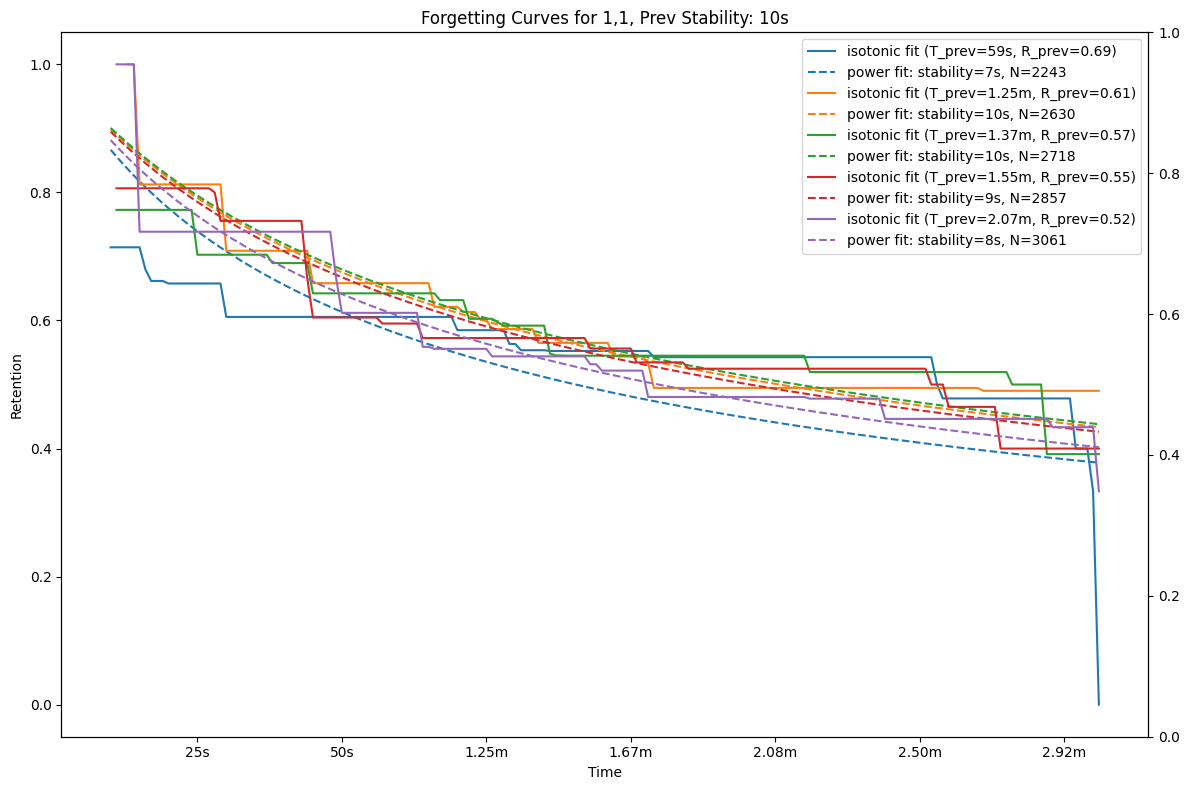

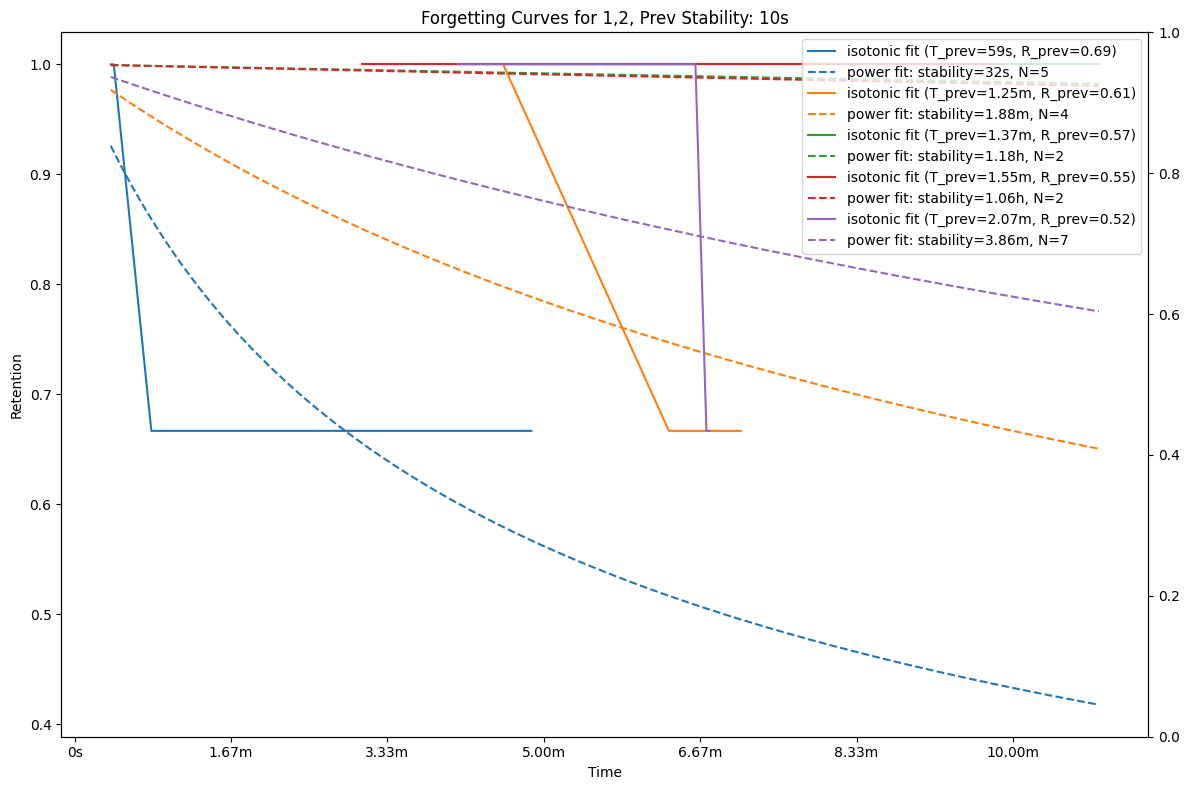

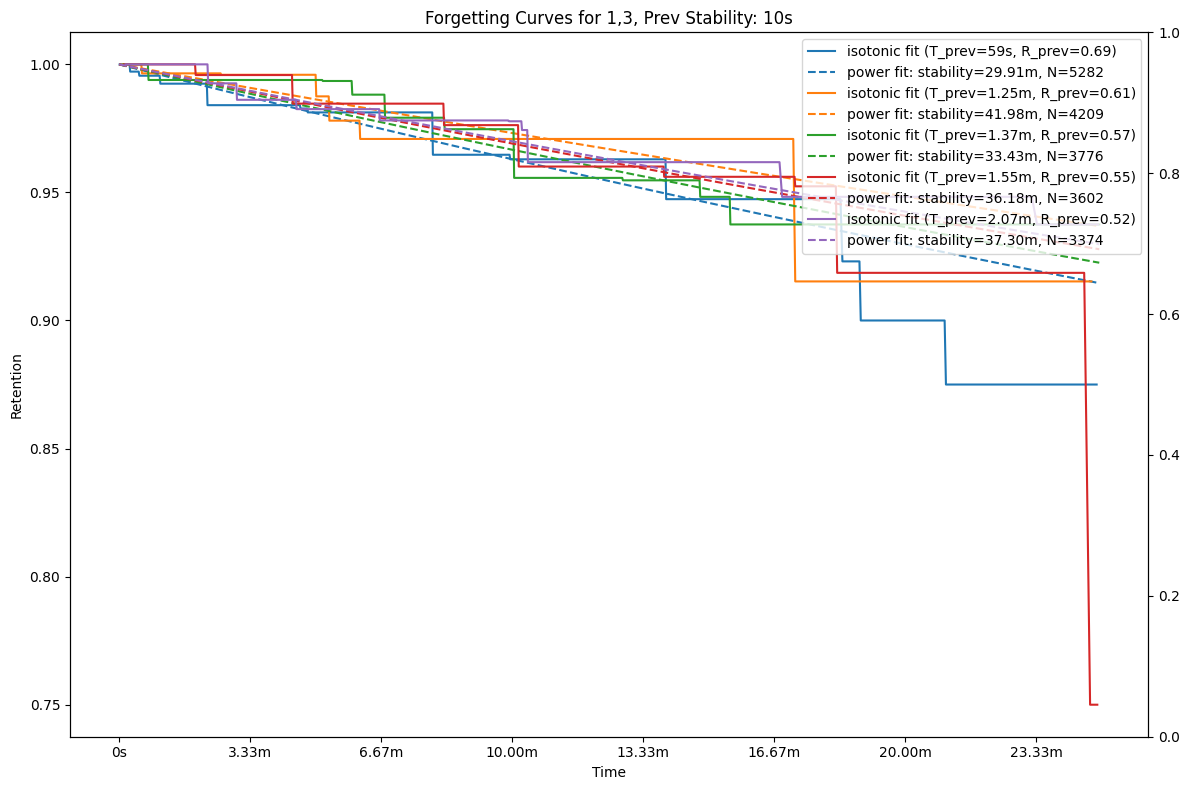

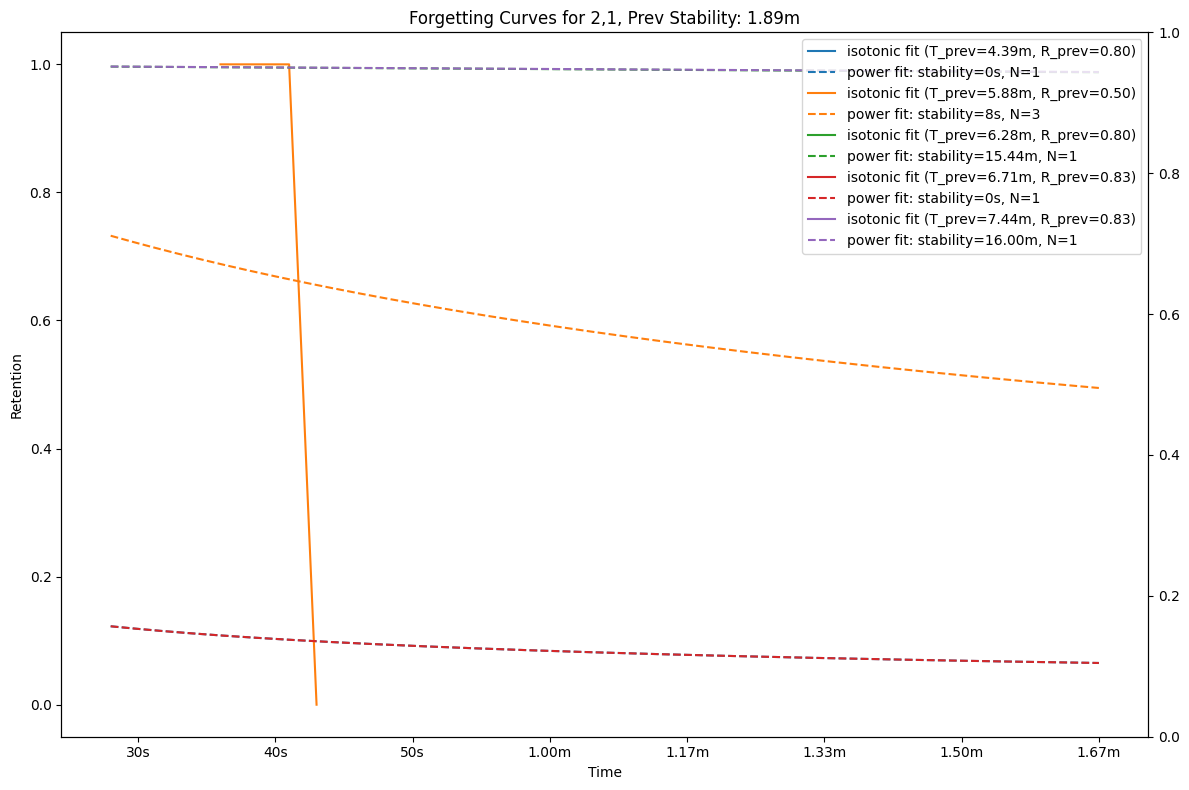

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


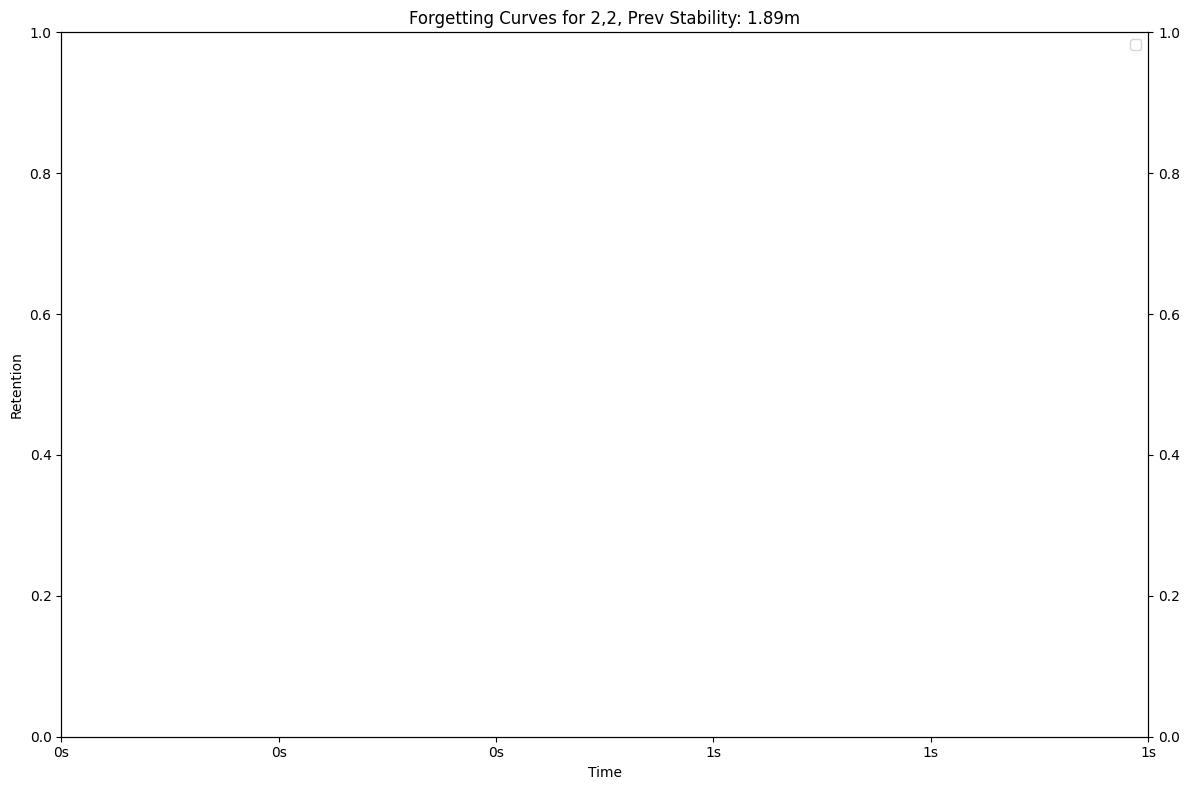

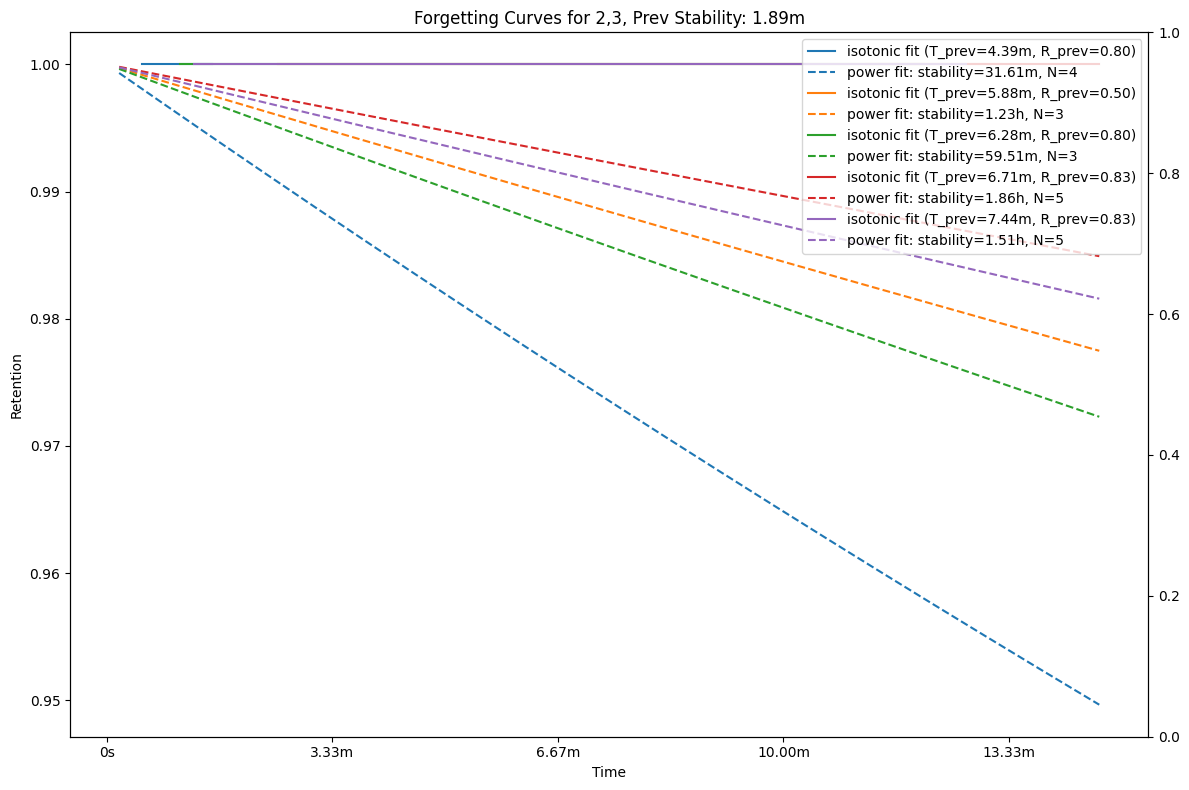

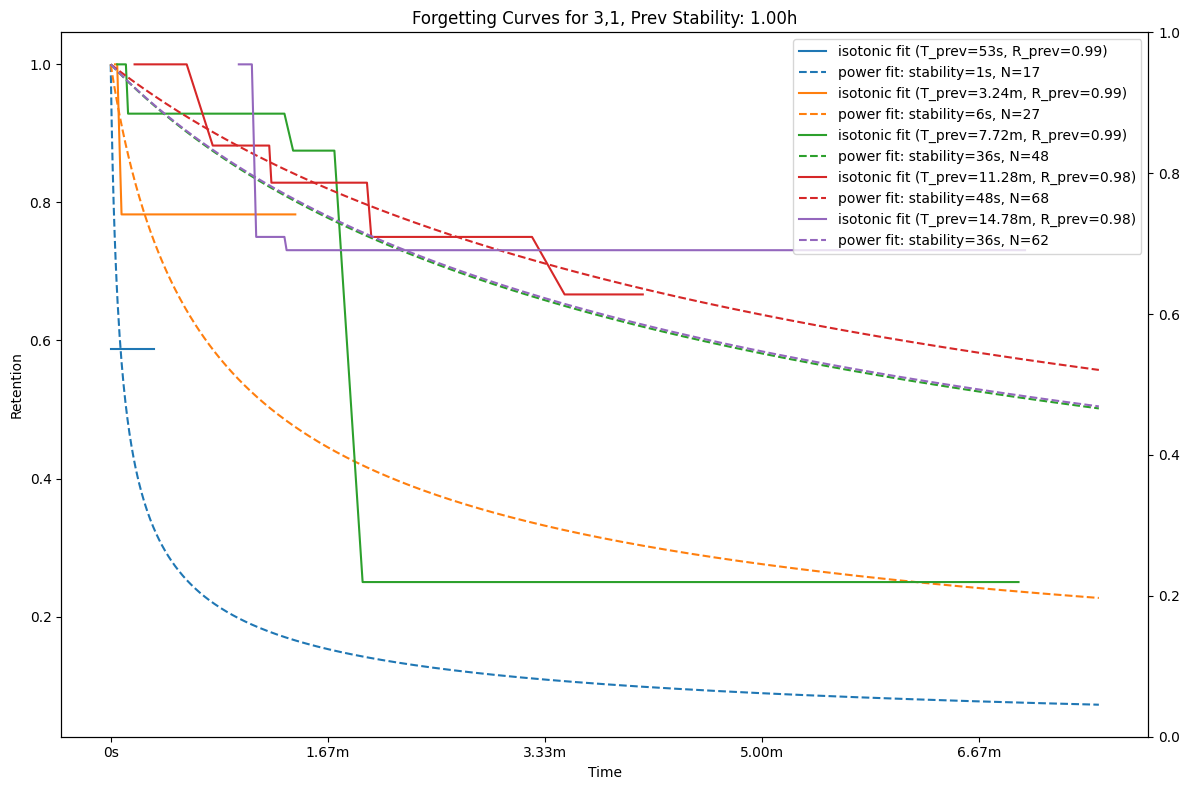

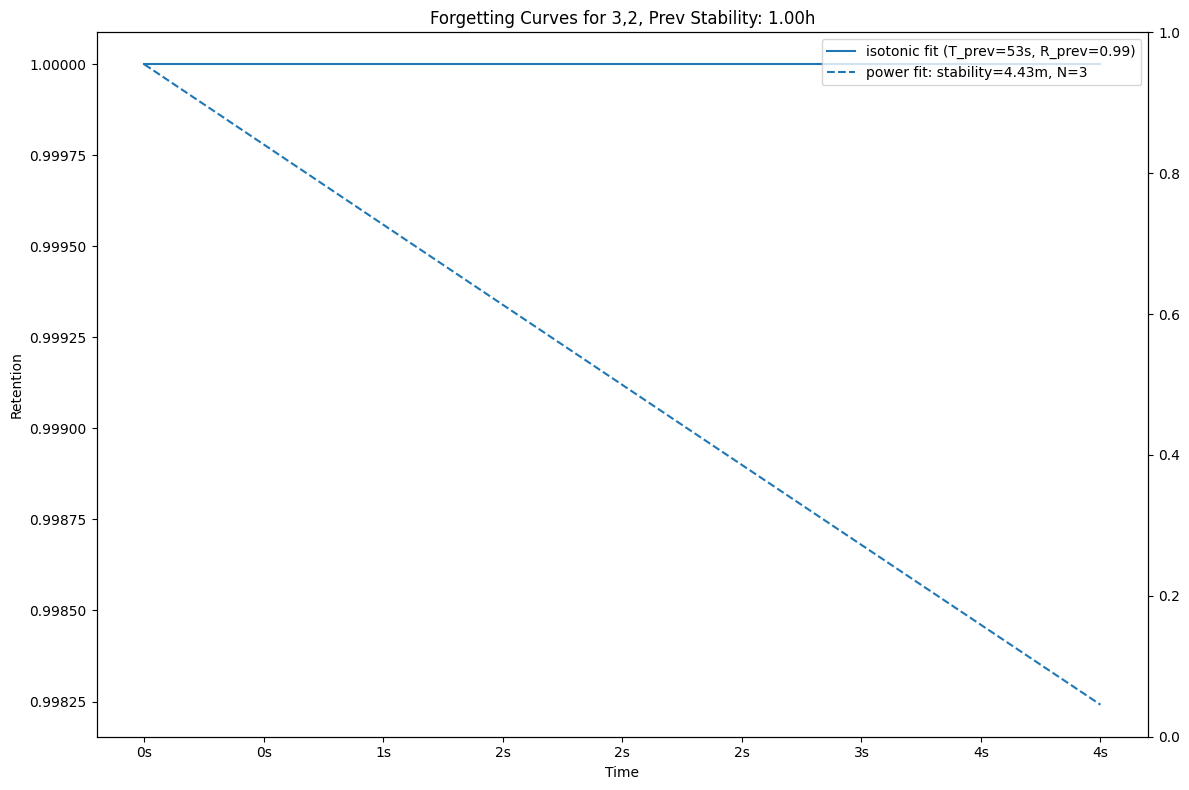

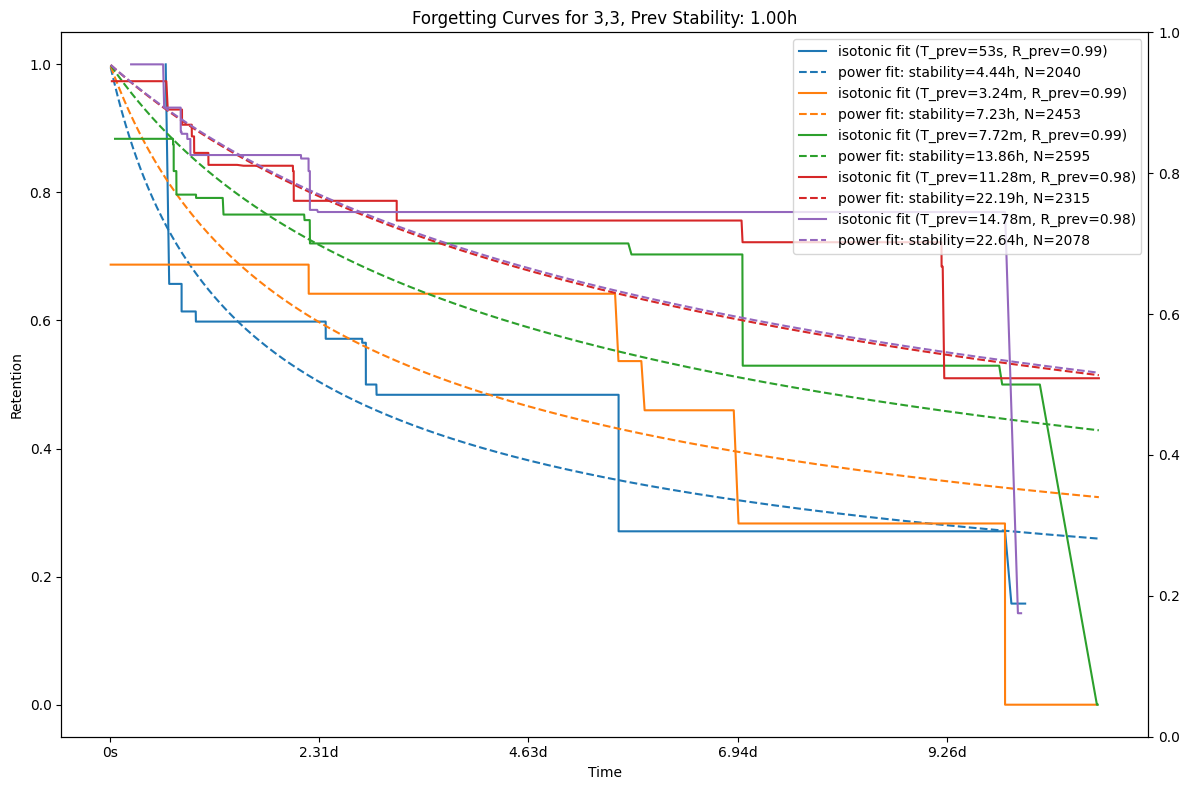

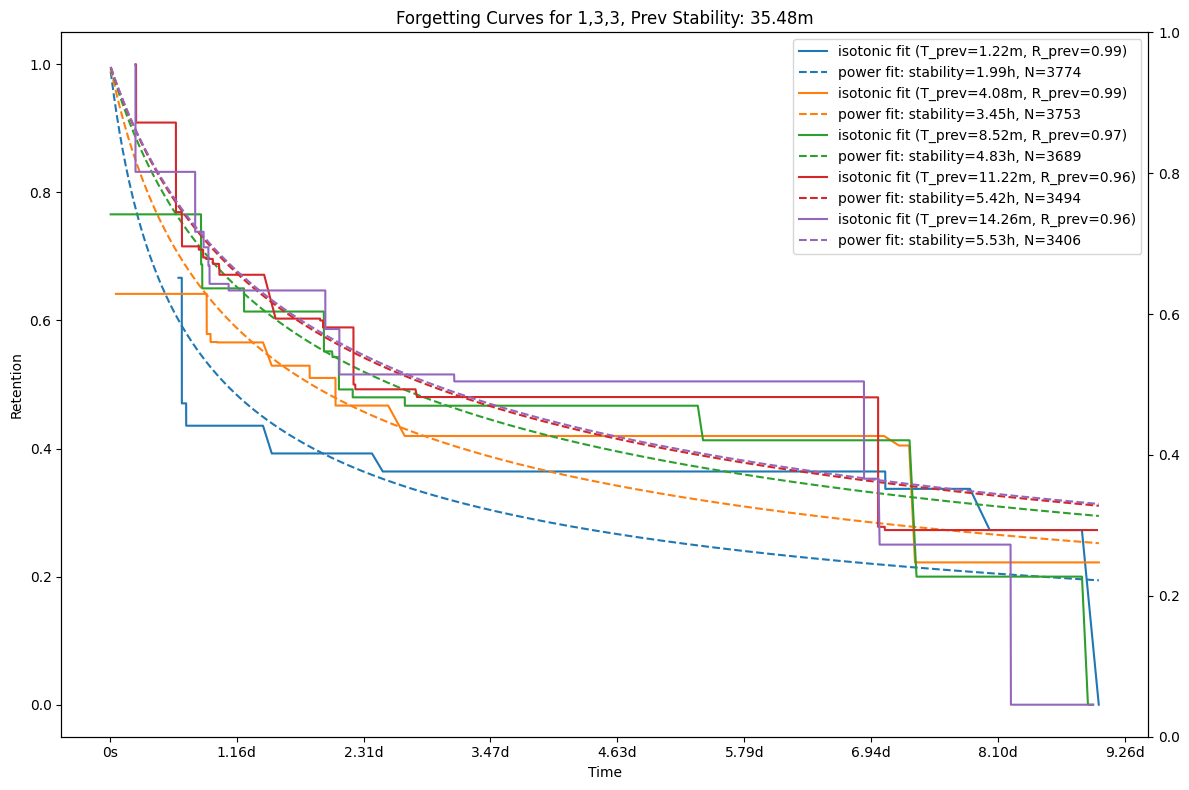

In [2]:
DECAY = -0.5


def power_forgetting_curve(t, s, decay=DECAY):
    factor = 0.9 ** (1 / decay) - 1
    return (1 + factor * t / s) ** decay


def fit_stability(delta_t, retention, size, decay=DECAY):

    def loss(stability):
        y_pred = power_forgetting_curve(delta_t, stability, decay).clip(
            1e-10, 1 - 1e-10
        )
        loss = sum(
            -(retention * np.log(y_pred) + (1 - retention) * np.log(1 - y_pred)) * size
        )
        return loss

    res = minimize(loss, x0=1, bounds=[(0.1, None)])
    return res.x[0]


def format_time(x, pos=None):
    if x < 60:
        return f"{x:.0f}s"
    elif x < 3600:
        return f"{x/60:.2f}m"
    elif x < 86400:
        return f"{x/3600:.2f}h"
    else:
        return f"{x/86400:.2f}d"


def filter_data(data):
    Q1 = data["elapsed_seconds"].quantile(0.25)
    Q3 = data["elapsed_seconds"].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data = data[
        (data["elapsed_seconds"] >= lower_bound)
        & (data["elapsed_seconds"] <= upper_bound)
    ]
    return data


r_history_list = ["1,1", "1,2", "1,3", "2,1", "2,2", "2,3", "3,1", "3,2", "3,3", "1,3,3"]
r_history_delta_t_bounds = {}
N = 5  # Can be adjusted to any number

df = df[df["r_history"].isin(r_history_list + ["1", "2", "3"])]
df = (
    df.groupby("r_history", as_index=True)
    .apply(filter_data, include_groups=False)
    .reset_index(level="r_history")
)

stats_data = {}

for r_history in r_history_list:

    stats_data[r_history] = []

    fig, ax1 = plt.subplots(figsize=(12, 8))
    data = df[df["r_history"] == r_history][["elapsed_seconds", "y", "t_history"]]
    # data = filter_data(data)
    r_history_delta_t_bounds[r_history] = (
        data["elapsed_seconds"].min(),
        data["elapsed_seconds"].max(),
    )

    if len(r_history) > 1:
        prev_data = df[df["r_history"] == r_history[:-2]]
        if prev_data.empty:
            continue
        # prev_data = filter_data(prev_data)
        prev_stability = fit_stability(
            prev_data["elapsed_seconds"],
            prev_data["y"],
            np.ones_like(prev_data["elapsed_seconds"]),
        )

        # Get previous interval from t_history
        data["prev_interval"] = data["t_history"].apply(
            lambda x: [float(i) for i in x.split(",")][-1]
        )

        # Split into N groups based on percentiles
        percentiles = np.linspace(0, 100, N + 1)
        interval_bounds = np.percentile(prev_data["elapsed_seconds"], percentiles)

        datasets = []
        labels = []

        for i in range(N):
            # Filter data for current interval range
            mask = (data["prev_interval"] > interval_bounds[i]) & (
                data["prev_interval"] <= interval_bounds[i + 1]
            )
            if mask.sum() == 0:
                continue

            datasets.append(data[mask])

            # Calculate stats for current interval range
            prev_mask = (prev_data["elapsed_seconds"] > interval_bounds[i]) & (
                prev_data["elapsed_seconds"] <= interval_bounds[i + 1]
            )
            # median_ivl = prev_data[prev_mask]["elapsed_seconds"].median()
            avg_ivl = prev_data[prev_mask]["elapsed_seconds"].mean()
            avg_retention = prev_data[prev_mask]["y"].mean()

            labels.append(
                f"(T_prev={format_time(avg_ivl)}, R_prev={avg_retention:.2f})"
            )

            stats_data[r_history].append(
                {
                    "r_history": r_history,
                    "prev_stability": prev_stability,
                    "prev_avg_interval": avg_ivl,
                    "prev_avg_retention": avg_retention,
                }
            )
    else:
        datasets = [data]
        labels = [r_history]

    ax2 = ax1.twinx()
    for idx, dataset in enumerate(datasets):
        x, y = dataset.sort_values(by="elapsed_seconds")[
            ["elapsed_seconds", "y"]
        ].values.T

        ir = IsotonicRegression(y_min=0, y_max=1, increasing=False)
        ir.fit(x, y)
        y_ir = ir.predict(x)

        s_seconds = fit_stability(x, y_ir, np.ones_like(x))
        x_ = np.linspace(
            r_history_delta_t_bounds[r_history][0],
            r_history_delta_t_bounds[r_history][1],
            1000,
        )
        y_pred = power_forgetting_curve(x_, s_seconds)
        cnt = len(x)

        ax1.plot(x, y_ir, "-", label=f"isotonic fit {labels[idx]}", color=f"C{idx}")
        ax1.plot(
            x_,
            y_pred,
            "--",
            label=f"power fit: stability={format_time(s_seconds)}, N={cnt}",
            color=f"C{idx}",
        )

        stats_data[r_history][idx]["stability"] = s_seconds
        stats_data[r_history][idx]["sample_size"] = cnt

        # unique_y_ir = np.unique(y_ir)
        # segment_counts = []
        # segment_x = []
        # segment_widths = []
        # for i in range(len(unique_y_ir)):
        #     mask = y_ir == unique_y_ir[i]
        #     segment_counts.append(np.sum(mask))
        #     segment_x.append(np.min(x[mask]))
        #     segment_widths.append(np.max(x[mask]) - np.min(x[mask]))

        # ax2.bar(
        #     segment_x,
        #     segment_counts,
        #     alpha=0.3,
        #     width=segment_widths,
        #     color=f"C{idx}",
        #     align="edge",
        # )

    ax1.set_xlabel("Time")
    ax1.set_ylabel("Retention")
    # ax2.set_ylabel("Sample Size")
    ax1.legend(loc="upper right")
    ax1.set_title(
        f"Forgetting Curves for {r_history}, Prev Stability: {format_time(prev_stability)}"
    )

    ax1.xaxis.set_major_formatter(plt.FuncFormatter(format_time))

    plt.tight_layout()
    plt.show()

In [3]:
flat_data = []
for r_history, groups in stats_data.items():
    for group in groups:
        flat_data.append(group)

df_stats = pd.DataFrame(flat_data)

df_stats = df_stats[['r_history', 'prev_stability', 'prev_avg_interval', 'prev_avg_retention', 'stability', 'sample_size']]

df_stats["SInc"] = df_stats["stability"] / df_stats["prev_stability"]

df_stats

,r_history,prev_stability,prev_avg_interval,prev_avg_retention,stability,sample_size,SInc
0,"1,1",10.424052,59.437220,0.686721,7.073380,2243,0.678563
1,"1,1",10.424052,75.080597,0.611410,9.827914,2630,0.942811
2,"1,1",10.424052,82.225454,0.574489,10.080350,2718,0.967028
3,"1,1",10.424052,93.285957,0.552076,9.427475,2857,0.904396
4,"1,1",10.424052,124.274234,0.515320,8.191474,3061,0.785824
5,"1,2",10.424052,59.437220,0.686721,32.455393,5,3.113510
6,"1,2",10.424052,75.080597,0.611410,112.594601,4,10.801424
7,"1,2",10.424052,82.225454,0.574489,4245.938317,2,407.321299
8,"1,2",10.424052,93.285957,0.552076,3808.880236,2,365.393449
9,"1,2",10.424052,124.274234,0.515320,231.580441,7,22.215972


In [4]:
# Group by r_history and calculate correlations for each group
weighted_corr_matrices = []
total_samples = 0

for r_history in df_stats['r_history'].unique():
    group_data = df_stats[df_stats['r_history'] == r_history]
    print(f"\nCorrelations for r_history = {r_history}:")
    corr_matrix = group_data[['prev_avg_interval', 'prev_avg_retention', 'SInc']].corr()
    print(corr_matrix)

    if corr_matrix.isnull().any().any():
        continue
    
    # Weight by total sample size for this group
    group_samples = group_data['sample_size'].sum()
    weighted_corr_matrices.append((corr_matrix, group_samples))
    total_samples += group_samples

# Calculate weighted average correlation matrix
weighted_avg_corr = sum(matrix * weight for matrix, weight in weighted_corr_matrices) / total_samples

print("\nWeighted average correlation matrix across all groups:")
print(weighted_avg_corr)



Correlations for r_history = 1,1:
                    prev_avg_interval  prev_avg_retention      SInc
prev_avg_interval            1.000000           -0.926773  0.086344
prev_avg_retention          -0.926773            1.000000 -0.430938
SInc                         0.086344           -0.430938  1.000000

Correlations for r_history = 1,2:
                    prev_avg_interval  prev_avg_retention      SInc
prev_avg_interval            1.000000           -0.926773  0.054037
prev_avg_retention          -0.926773            1.000000 -0.366543
SInc                         0.054037           -0.366543  1.000000

Correlations for r_history = 1,3:
                    prev_avg_interval  prev_avg_retention      SInc
prev_avg_interval            1.000000           -0.926773  0.363042
prev_avg_retention          -0.926773            1.000000 -0.449456
SInc                         0.363042           -0.449456  1.000000

Correlations for r_history = 2,1:
                    prev_avg_interval  prev_

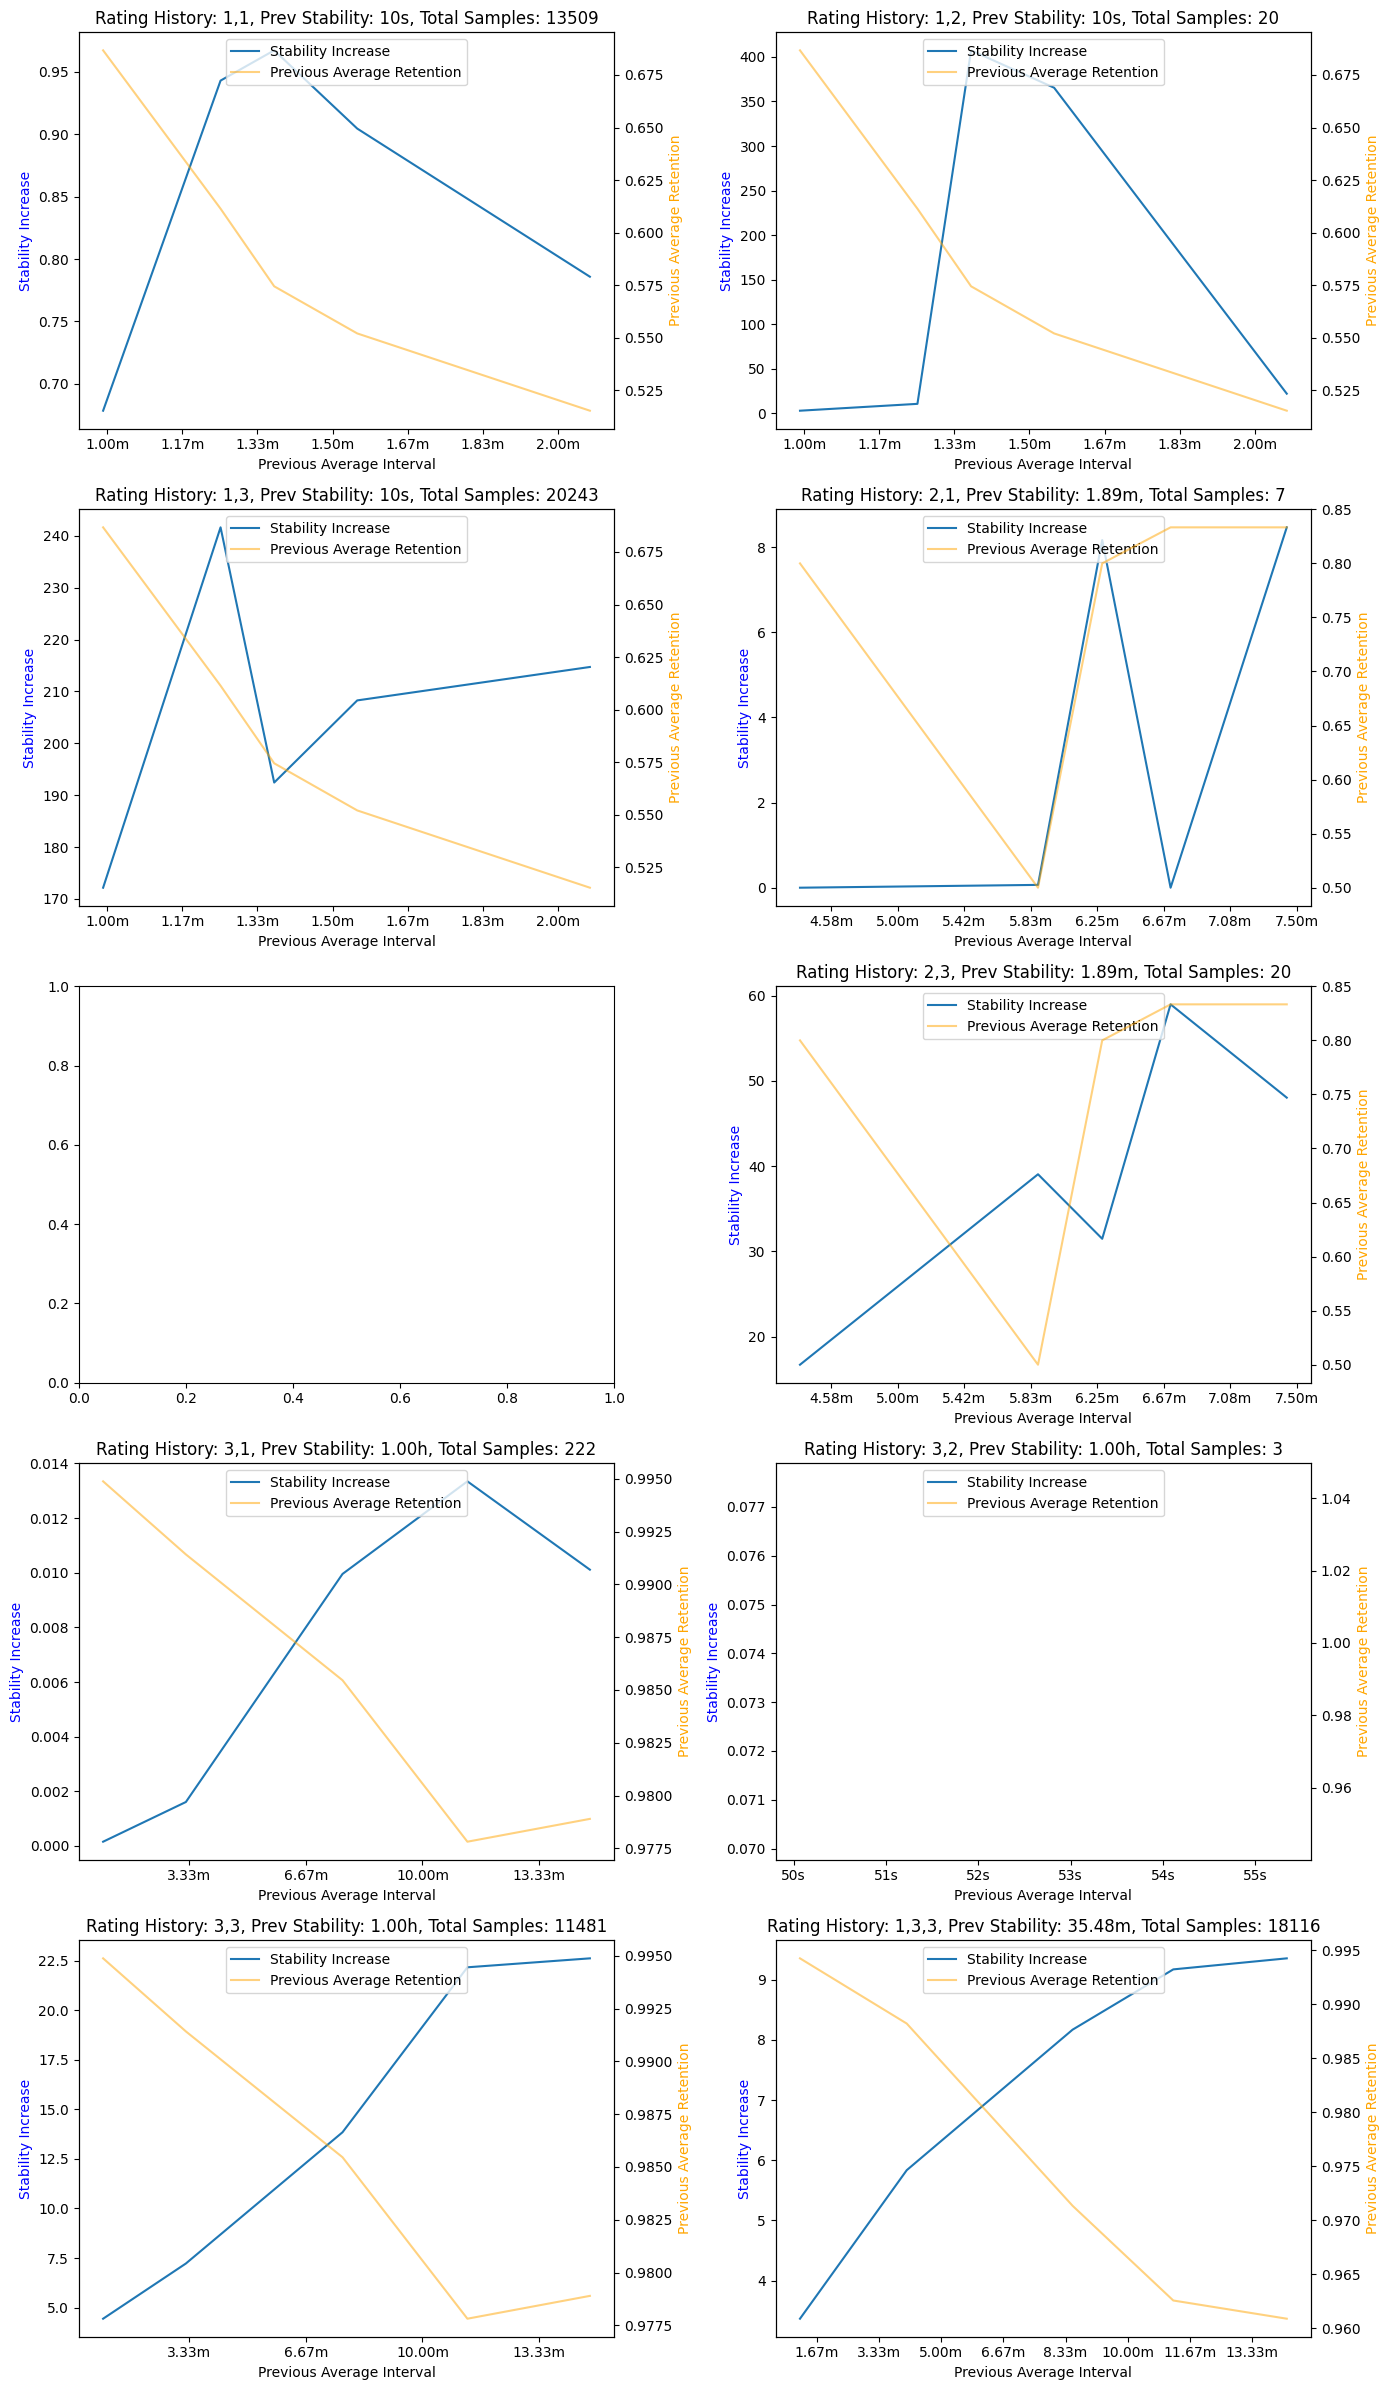

In [5]:
fig, axes = plt.subplots(5, 2, figsize=(14, 24))
axes = axes.flatten()

for idx, r_history in enumerate(r_history_list):
    data = df_stats[df_stats['r_history'] == r_history]

    if data.empty:
        continue
    
    ax1 = axes[idx]
    ax2 = ax1.twinx()
    
    # Plot stability increase vs previous average interval
    line1 = ax1.plot(data['prev_avg_interval'], data['SInc'], '-', label='Stability Increase')
    
    # Plot previous average retention on secondary y-axis
    line2 = ax2.plot(data['prev_avg_interval'], data['prev_avg_retention'],
                    alpha=0.5, color='orange', label='Previous Average Retention')
    
    # Customize the plot
    ax1.set_xlabel('Previous Average Interval')
    ax1.set_ylabel('Stability Increase', color='blue')
    ax2.set_ylabel('Previous Average Retention', color='orange')

    total_samples = data['sample_size'].sum()
    
    # Add title
    ax1.set_title(f'Rating History: {r_history}, Prev Stability: {format_time(data["prev_stability"].iloc[0])}, Total Samples: {total_samples}')
    
    # Combine legends
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper center')
    ax1.xaxis.set_major_formatter(plt.FuncFormatter(format_time))

plt.tight_layout()
plt.show()